In [1]:
import sys
import glob
sys.path.append("../")
import CryoAsicAnalysis
import CryoAsicFile
import yaml
import pickle
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
plt.style.use("~/evanstyle.mplstyle")

In [2]:
datapath = "../../../data/MockTileRun1/CathodePulser/"
datfiles = glob.glob(datapath+"*.dat")
pfiles = glob.glob(datapath+"*.p")

config_filepath = "../config/analysisconfig.yml"
print(datfiles)

['../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_2.4pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_3.6pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_1.2pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_0.6pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1.5g_3.6pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1.5g_1.2pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_3g_1.2pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_3g_3.6pt_50000us_file0.dat', '../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_3.6pt_50000us_file0.dat', '../../../data

In [3]:
#check if any dat files haven't been converted yet, and do so
#OR you can auto reload all files
reload_all = False
for df in datfiles:
    filetag = df.split("/")[-1]
    filetag = filetag[:-4]
    found = False
    for pf in pfiles:
        pfiletag = pf.split("/")[-1]
        pfiletag = pfiletag[:-2]
        if(pfiletag == filetag):
            found = True
            break
    
    #if no pickle matching file was found, do the conversion
    if(found == False or reload_all):
        cf = CryoAsicFile.CryoAsicFile(df, config_filepath)
        cf.load_raw_data()
        cf.group_into_pandas()
        outfile_name = datapath+filetag+".p"
        cf.pickle_dump_waveform_df(outfile_name)



Read 2 events from CRYO ASIC file
Read 4 events from CRYO ASIC file
Read 6 events from CRYO ASIC file
Read 8 events from CRYO ASIC file
Read 10 events from CRYO ASIC file
Message
 <class 'IndexError'>
size [] previous size [12800016 16777218]
numberOfFrames read:  10
Finished reading raw binary, now descrambling the data
Done loading 10 CRYO ASIC events
Saving dataframe to file: ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_2.4pt_50000us_file0.p
Read 2 events from CRYO ASIC file
Read 4 events from CRYO ASIC file
Read 6 events from CRYO ASIC file
Read 8 events from CRYO ASIC file
Read 10 events from CRYO ASIC file
Message
 <class 'IndexError'>
size [] previous size [12800016 16777218]
numberOfFrames read:  10
Finished reading raw binary, now descrambling the data
Done loading 10 CRYO ASIC events
Saving dataframe to file: ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_3.6pt_50000us_file0.p
Read 2 events from CRYO ASIC

In [63]:
def get_ca_from_settings(gsel, ptsel):
    ca = None
    for pf in pfiles:
        with open(config_filepath, 'r') as f:
            config = yaml.safe_load(f)

        filetag = pf.split("/")[-1]
        spl = filetag.split("_")
        gain = None
        pt = None 
        for _ in spl:
            if("g" in _):
                gain = float(_.replace("g",""))
            if("pt" in _):
                pt = float(_.replace("pt",""))
        
        if(pt == None or gain == None):
            print("Issue parsing gain and pt from filetag")
            continue

        if(gain != gsel or pt != ptsel):
            continue


        config["gain"] = gain 
        config["pt"] = pt 
        ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
        ca.baseline_subtract()
    if(ca is None):
        print("these settings don't seem to be in the file path exist: {:.1f} gain {:.1f} pt".format(gsel, ptsel))
        return None
    return ca

In [62]:
pfiles = glob.glob(datapath+"*.p")

output = {}
for pf in pfiles:
    with open(config_filepath, 'r') as f:
        config = yaml.safe_load(f)

    filetag = pf.split("/")[-1]
    spl = filetag.split("_")
    gain = None
    pt = None 
    for _ in spl:
        if("g" in _):
            gain = float(_.replace("g",""))
        if("pt" in _):
            pt = float(_.replace("pt",""))
    
    if(pt == None or gain == None):
        print("Issue parsing gain and pt from filetag")

    config["gain"] = gain 
    config["pt"] = pt 
    output[tuple([gain, pt])] = {}

    ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
    ca.baseline_subtract()
    detected_chs = []
    ch_max = []
    capacitance = [] #pF
    pulse_amplitude = 2 #V 

    #find the max amplitude over all channels, as that can set a scale for the
    #threshold
    max_amplitude = 0
    for i in range(64):
        wave = ca.get_wave(0, i)
        if(np.max(wave) > max_amplitude):
            max_amplitude = np.max(wave)
            
    thresh = max_amplitude*0.3
    for i in range(64):
        wave = ca.get_wave(0, i)
        if(np.max(wave) > thresh):
            ch_max.append(ca.ADC_to_ENC(np.max(wave))*1.6e-19*1e15)
            capacitance.append(ch_max[-1]/pulse_amplitude) #fF
            detected_chs.append(i)

    #sort simultaneously by channel number 
    print(detected_chs)
    detected_chs, ch_max, capacitance = zip(*sorted(zip(detected_chs, ch_max, capacitance)))
    
    output[tuple([gain, pt])]["chs"] = detected_chs
    output[tuple([gain, pt])]["max"] = ch_max
    output[tuple([gain, pt])]["capacitance"] = capacitance


    



loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_0.6pt_50000us_file0.p
Done loading
[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63]
loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_3.6pt_50000us_file0.p
Done loading
[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63]
loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_3g_2.4pt_50000us_file0.p
Done loading
[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63]
loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_1g_0.6pt_50000us_file0.p
Done loading
[0, 1, 2, 3, 8, 9, 10, 11, 

In [17]:
for tup in output:
    print(tup, end=" ")
    typs = []
    print(output[tup]["chs"])
    for ch in output[tup]["chs"]:
        typs.append(ca.get_channel_type(ch))
    print(tuple(typs))
    

(6.0, 0.6) (0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63)
('x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y')
(1.0, 3.6) (0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63)
('x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y')
(3.0, 2.4) (0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63)
('x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y', 'y')
(1.0, 0.6) (0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27, 36, 37, 38, 39, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 63)
('x', 'x', '

loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_3.6pt_50000us_file0.p
Done loading


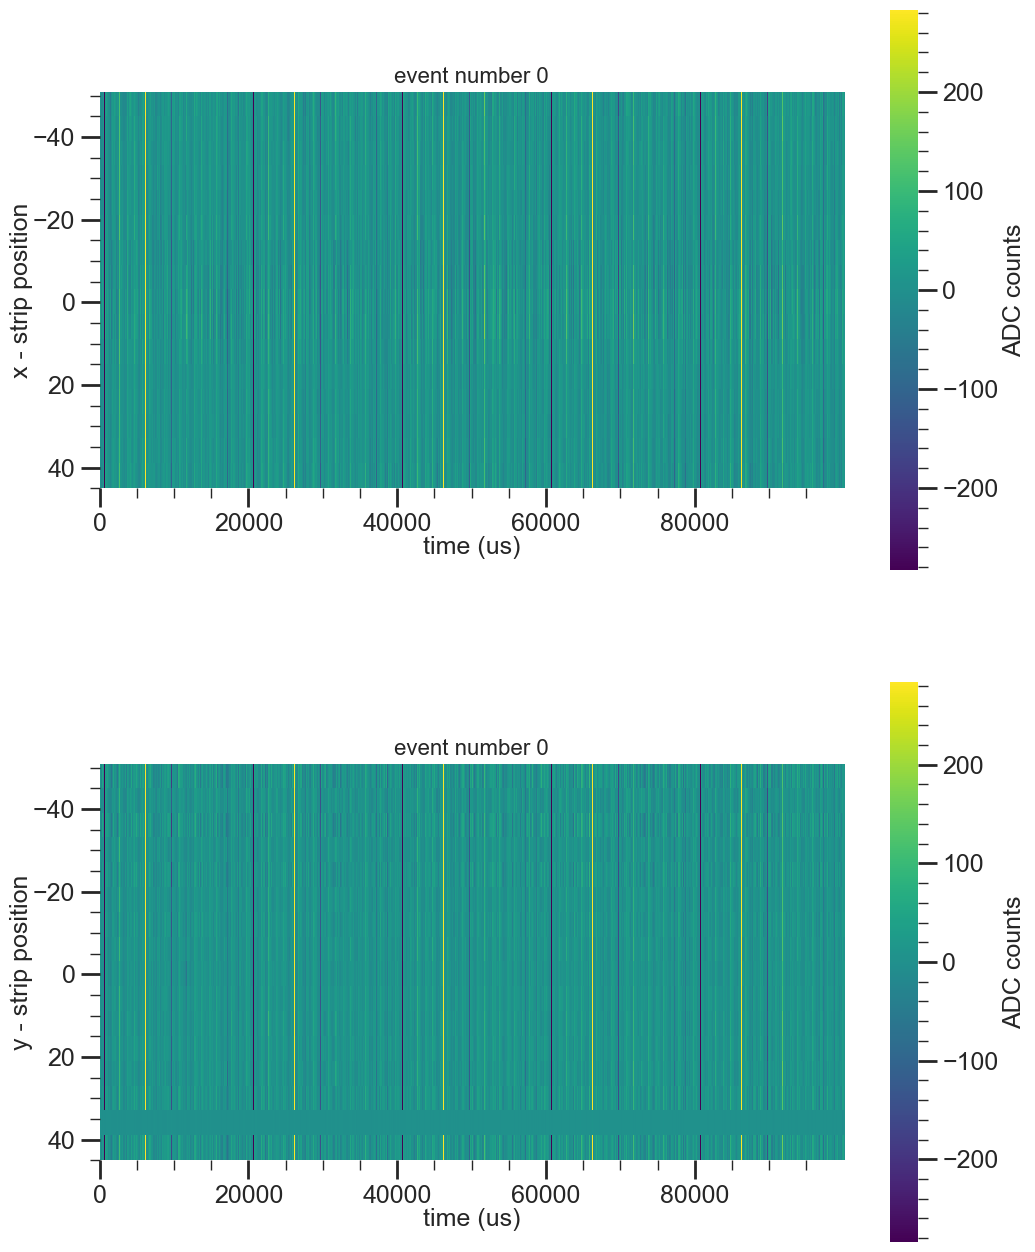

In [26]:
gsel = 6
ptsel = 3.6
for pf in pfiles:
    with open(config_filepath, 'r') as f:
        config = yaml.safe_load(f)

    filetag = pf.split("/")[-1]
    spl = filetag.split("_")
    gain = None
    pt = None 
    for _ in spl:
        if("g" in _):
            gain = float(_.replace("g",""))
        if("pt" in _):
            pt = float(_.replace("pt",""))
    
    if(pt == None or gain == None):
        print("Issue parsing gain and pt from filetag")

    if(gain != gsel or pt != ptsel):
        continue


    config["gain"] = gain 
    config["pt"] = pt 
    ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
    ca.baseline_subtract()
    fig, ax = ca.plot_event_xysep(0, show=False)
    #ax[0].set_xlim([20000, 30000])
    #ax[1].set_xlim([20000, 30000])
    #ax[0].set_aspect('auto', 'box')
    #ax[1].set_aspect('auto', 'box')
    plt.show()
    
    

loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_3.6pt_50000us_file0.p
Done loading
loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_2.4pt_50000us_file0.p
Done loading
loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_1.2pt_50000us_file0.p
Done loading


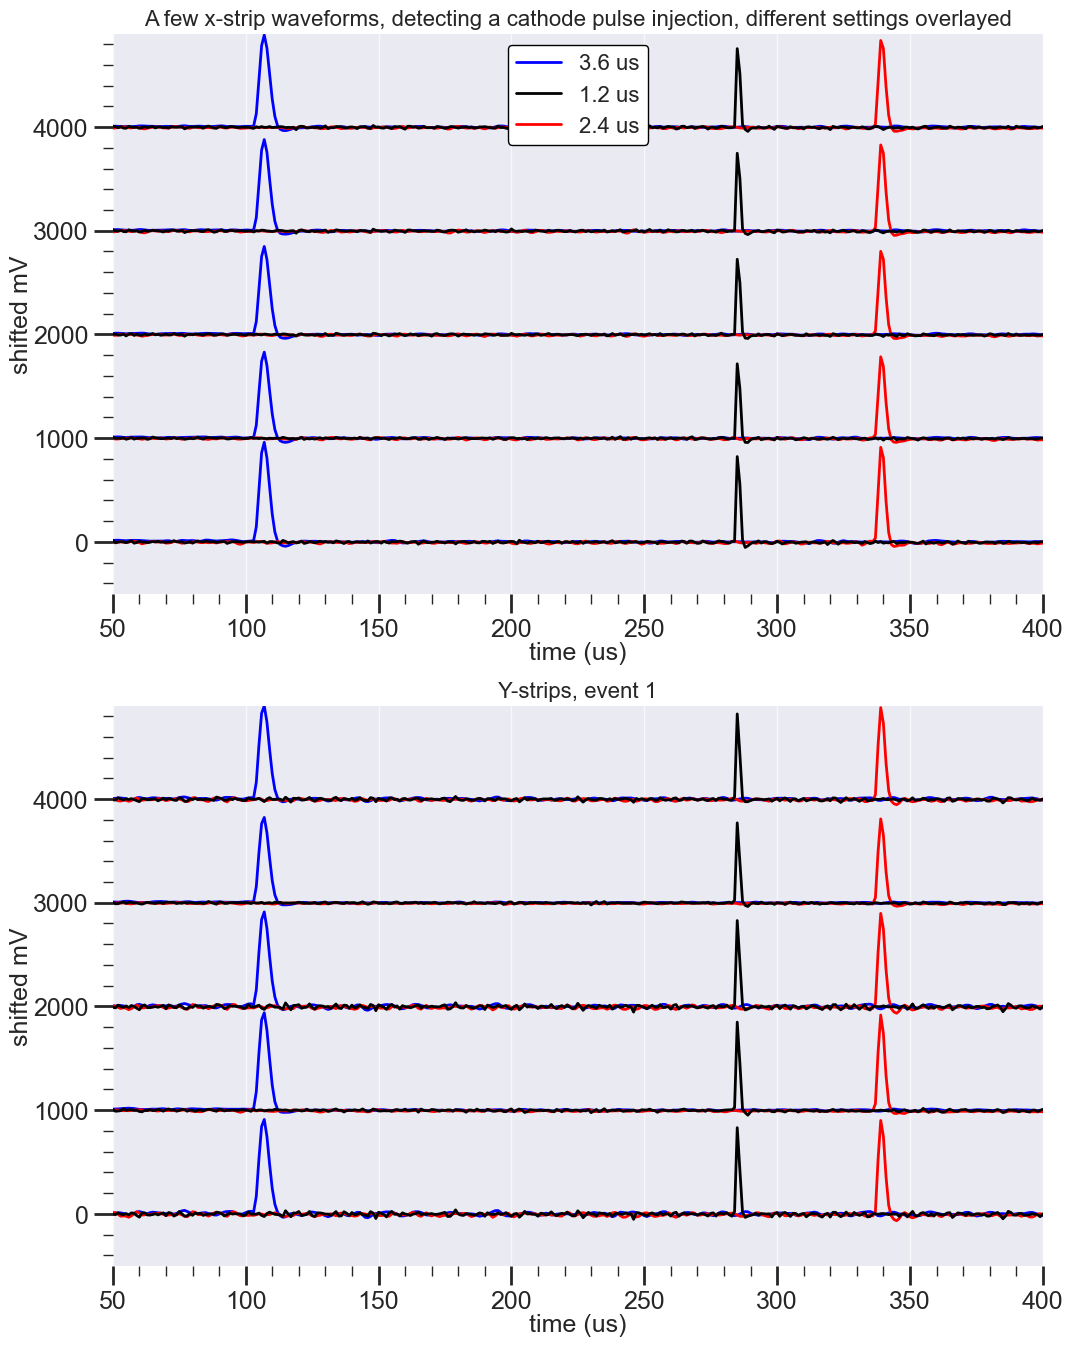

In [56]:
from matplotlib.lines import Line2D
gsel = 6
ptsel = 3.6
for pf in pfiles:
    with open(config_filepath, 'r') as f:
        config = yaml.safe_load(f)

    filetag = pf.split("/")[-1]
    spl = filetag.split("_")
    gain = None
    pt = None 
    for _ in spl:
        if("g" in _):
            gain = float(_.replace("g",""))
        if("pt" in _):
            pt = float(_.replace("pt",""))
    
    if(pt == None or gain == None):
        print("Issue parsing gain and pt from filetag")

    if(gain != gsel or pt != ptsel):
        continue


    config["gain"] = gain 
    config["pt"] = pt 
    ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
    ca.baseline_subtract()
    break

fig, ax = ca.plot_strips_waveforms_separated(0, fmt='b', show=False, sep=1000)

gsel = 6
ptsel = 2.4
for pf in pfiles:
    with open(config_filepath, 'r') as f:
        config = yaml.safe_load(f)

    filetag = pf.split("/")[-1]
    spl = filetag.split("_")
    gain = None
    pt = None 
    for _ in spl:
        if("g" in _):
            gain = float(_.replace("g",""))
        if("pt" in _):
            pt = float(_.replace("pt",""))
    
    if(pt == None or gain == None):
        print("Issue parsing gain and pt from filetag")

    if(gain != gsel or pt != ptsel):
        continue


    config["gain"] = gain 
    config["pt"] = pt 
    ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
    ca.baseline_subtract()
    break

ca.plot_strips_waveforms_separated(0, fmt='r', fig = None, ax=ax, show=False, sep=1000)


gsel = 6
ptsel = 1.2
for pf in pfiles:
    with open(config_filepath, 'r') as f:
        config = yaml.safe_load(f)

    filetag = pf.split("/")[-1]
    spl = filetag.split("_")
    gain = None
    pt = None 
    for _ in spl:
        if("g" in _):
            gain = float(_.replace("g",""))
        if("pt" in _):
            pt = float(_.replace("pt",""))
    
    if(pt == None or gain == None):
        print("Issue parsing gain and pt from filetag")

    if(gain != gsel or pt != ptsel):
        continue


    config["gain"] = gain 
    config["pt"] = pt 
    ca = CryoAsicAnalysis.CryoAsicAnalysis(pf, config=config)
    ca.baseline_subtract()
    break

ca.plot_strips_waveforms_separated(1, fmt='k-', fig = None, ax=ax, show=False, sep=1000)


ax[0].set_xlim([50, 400])
ax[1].set_xlim([50, 400])
ax[1].set_ylim([-500, 4900])
ax[0].set_ylim([-500, 4900])
ax[0].set_title("A few x-strip waveforms, detecting a cathode pulse injection, different settings overlayed")

hands = [Line2D([0], [0], label='3.6 us', color='b'), Line2D([0], [0], label='1.2 us', color='k'), Line2D([0], [0], label='2.4 us', color='r')]
ax[0].legend(handles=hands, loc='upper center', facecolor='white', framealpha=1, edgecolor='k', frameon=True)
plt.show()

# More sophisticated capacitance calculator

In [131]:
ca = get_ca_from_settings(6, 3.6)

loading the waveform dataframe from  ../../../data/MockTileRun1/CathodePulser/FE_Sweep_Cathode_Pulser_2V_initcryo_4_6g_3.6pt_50000us_file0.p
Done loading


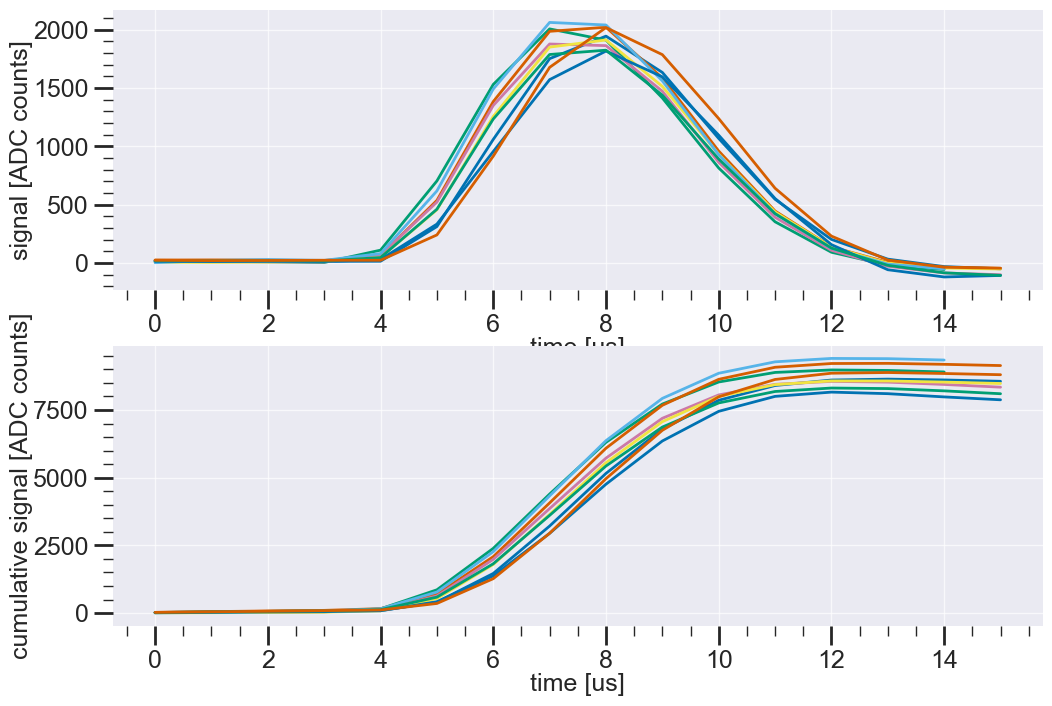

In [132]:
#some debugging validating the pulse finder is working
nevts = ca.nevents_total
for i in range(nevts):
    all_pulses = ca.find_pulses_in_event(i, n_sigma=40)
    #random sampling of pulses
    some_pulses = np.random.choice(all_pulses, 20)
    fig, (ax, axi) = plt.subplots(nrows = 2)
    for pulse in some_pulses:
        if(pulse["amplitude"] < 0): continue
        ch = pulse["channel"]
        wave = ca.get_wave(i, ch)
        buffer = int(5/ca.dT) #N microseconds, in samples
        wave_range = []
        if(len(pulse["index"]) == 1):
            wave_range = [pulse["index"][0]-buffer, pulse["index"][0]+buffer]
        else:
            wave_range = [pulse["index"][0]-buffer, pulse["index"][-1]+buffer]

        if(wave_range[0] < 0): wave_range[0] = 0
        if(wave_range[1] > len(wave)): wave_range[1] = len(wave)

        small_wave = wave[wave_range[0]:wave_range[1]]
        times = np.arange(len(small_wave))*ca.dT
        ax.plot(times, small_wave)
        

        axi.plot(times, np.cumsum(small_wave))
    
    ax.set_xlabel("time [us]")
    ax.set_ylabel("signal [ADC counts]")
    axi.set_xlabel("time [us]")
    axi.set_ylabel("cumulative signal [ADC counts]")
    plt.show()
    break




In [133]:
#some debugging validating the pulse finder is working
nevts = ca.nevents_total
integrals = []
amplitudes = []
for i in range(nevts):
    all_pulses = ca.find_pulses_in_event(i, n_sigma=40)
    #random sampling of pulses
    for pulse in all_pulses:
        if(pulse["amplitude"] < 0): continue
        ch = pulse["channel"]
        wave = ca.get_wave(i, ch)
        buffer = int(5/ca.dT) #N microseconds, in samples
        wave_range = []
        if(len(pulse["index"]) == 1):
            wave_range = [pulse["index"][0]-buffer, pulse["index"][0]+buffer]
        else:
            wave_range = [pulse["index"][0]-buffer, pulse["index"][-1]+buffer]

        if(wave_range[0] < 0): wave_range[0] = 0
        if(wave_range[1] > len(wave)): wave_range[1] = len(wave)

        small_wave = wave[wave_range[0]:wave_range[1]]
        times = np.arange(len(small_wave))*ca.dT
        amplitudes.append(np.max(small_wave))
        integrals.append(np.trapz(small_wave, dx=ca.dT))



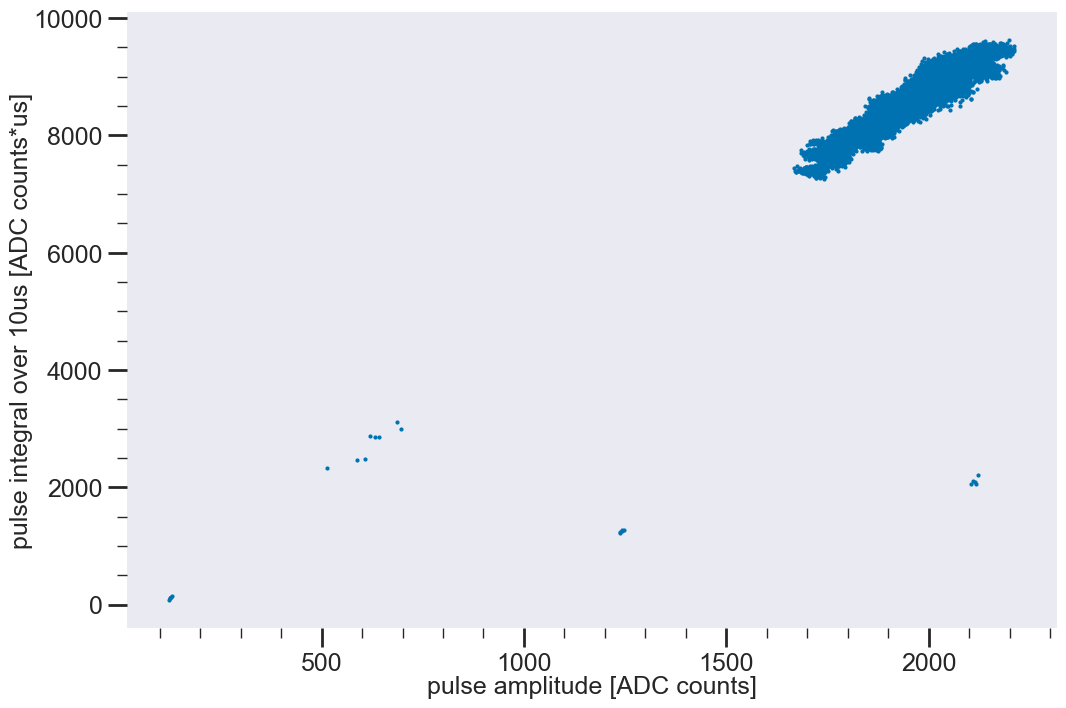

In [134]:
fig, ax = plt.subplots()
ax.scatter(amplitudes, integrals)
ax.set_xlabel("pulse amplitude [ADC counts]")
ax.set_ylabel("pulse integral over 10us [ADC counts*us]")
#ax.set_xlim([1500, 2500])
#ax.set_ylim([7000, 10000])
ax.grid(False)
plt.show()

In [135]:
#separate by channel, find the avg and std of capacitance
#some debugging validating the pulse finder is working
nevts = ca.nevents_total
outputs = {} #indexed by channel
V = 2 #Volts amplitude of input pulser
for i in range(nevts):
    all_pulses = ca.find_pulses_in_event(i, n_sigma=40)
    #random sampling of pulses
    for pulse in all_pulses:
        if(pulse["amplitude"] < 0): continue
        ch = pulse["channel"]
        if(ch not in outputs):
            outputs[ch] = []

        amp = pulse["amplitude"] #ADC counts
        charge = ca.ADC_to_ENC(amp)*1.6e-19 #Coulombs
        capacitance = charge/V*1e15 #fF
        outputs[ch].append(capacitance) #fF


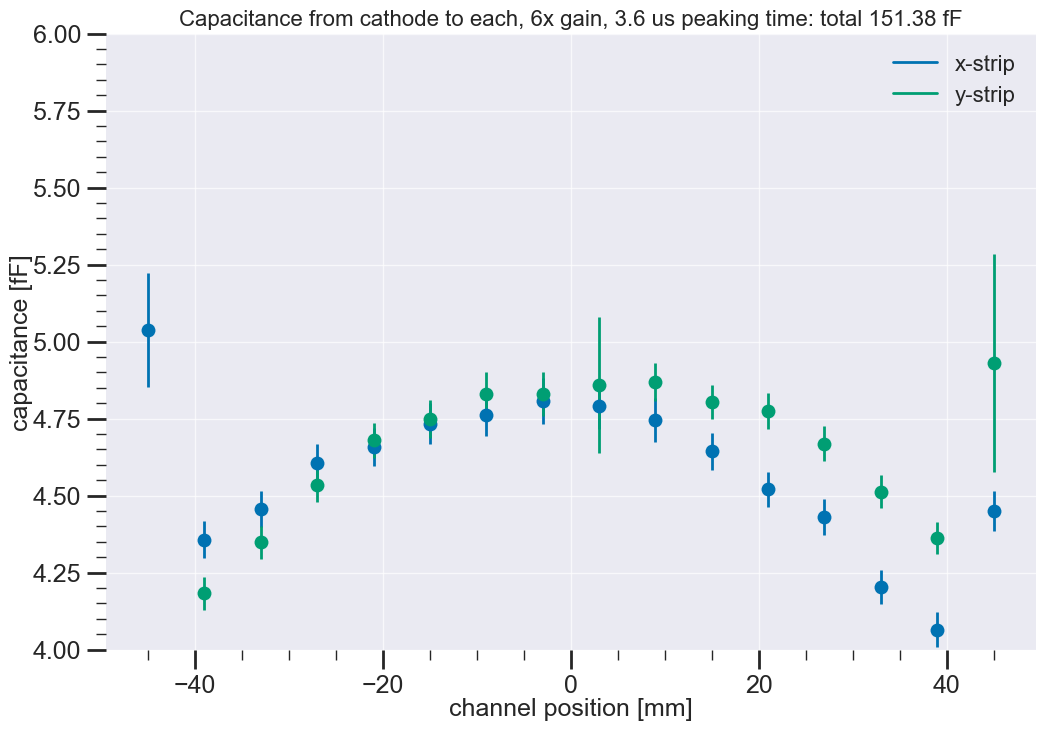

In [146]:
#get color cycler
ca.load_config(config_filepath)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots()
xc = colors[0]
yc = colors[1]
for ch in outputs:
    pos = ca.get_channel_pos(ch)
    typ = ca.get_channel_type(ch)
    if(typ == "x"):
        ax.errorbar([pos[1]], [np.mean(outputs[ch])], yerr=[np.std(outputs[ch])], fmt='o', color=xc, markersize=10)
    elif(typ == "y"):
        ax.errorbar([pos[0]], [np.mean(outputs[ch])], yerr=[np.std(outputs[ch])], fmt='o', color=yc, markersize=10)


#manually add legend labels 
hands = [Line2D([0], [0], label='x-strip', color=xc), Line2D([0], [0], label='y-strip', color=yc)]
ax.legend(handles=hands)
         
ax.set_ylim([4, 6])
ax.set_xlabel("channel position [mm]")
ax.set_ylabel("capacitance [fF]")
ax.set_title("Capacitance from cathode to each, 6x gain, 3.6 us peaking time: total {:.2f} fF".format(np.sum([np.mean(outputs[ch]) for ch in outputs])))
plt.show()